In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.externals import joblib
from sklearn import tree
from sklearn.grid_search import GridSearchCV

/home/expertsvision/Desktop/GA_implemented_with_flask/server/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/expertsvision/Desktop/GA_implemented_with_flask/server/venv/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
def get_time(x, c1, c2):     #find the difference between two date columns of dataframe x
    diff =  x[c2] - x[c1]
    days = diff.days
    days_to_hours = days * 24
    diff_btw_two_times = (diff.seconds) / 3600
    overall_hours = days_to_hours + diff_btw_two_times
    return overall_hours

In [4]:
file = 'delivery_new_nov_2018.xlsx'
data = pd.ExcelFile(file)
df = data.parse('Order History_1')

In [5]:
col_names= ['Created Time', 'Delivered Time','Total Orders to Assign', 'Qty']
df.dropna(subset=col_names, how='any', inplace = True)
col_names= ['Created Time', 'Delivered Time']

In [6]:
info_taken = pd.DataFrame()
df['Created Time'] = df['Created Time']
df['Hours2deliver']= df.apply(get_time, c1='Created Time', c2='Delivered Time', axis=1)
df['PendingOrdersLocationWise']= df['Total Orders to Assign']
df['LocationCode'], levels = pd.factorize(df['Location Code'])
df['CustomerCode'], levels = pd.factorize(df['Customer Code'])

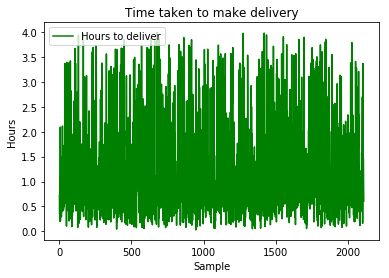

In [7]:
is_strange =  df['Hours2deliver']>4
df= df[~is_strange]
plt.plot(df['Hours2deliver'].values, color= 'green', label= 'Hours to deliver') # p
plt.ylabel('Hours')
plt.xlabel('Sample')
plt.title('Time taken to make delivery')
plt.legend()
plt.show()

In [9]:
timstamp_into_int = df['Created Time'].values.astype(int)
location_code = df[['LocationCode', 'CustomerCode']].values
X = np.insert(location_code, 1,timstamp_into_int , axis=1)
Y = np.reshape(df['Hours2deliver'].values, -1)
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.1, random_state=42)

In [17]:
tree_regression_model = tree.DecisionTreeRegressor(min_samples_split=25, max_depth=17, random_state=0)
trained_model = tree_regression_model.fit(X, Y)
joblib.dump(trained_model, 'model1_dt.sav')

['model1_dt.sav']

In [11]:
from sklearn.metrics import make_scorer
tree_regression_Model = tree.DecisionTreeRegressor(random_state=0)
scoring = make_scorer(r2_score)
parameters={'max_depth': np.arange(15, 30), 'min_samples_split':np.arange(15, 32)}
#cross_validation = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(tree_regression_Model, parameters, cv=15, n_jobs=4, refit=True, scoring=scoring,verbose=1)

In [12]:
#grid_search = tree.DecisionTreeRegressor(criterion='mae', random_state=0, max_depth=19, min_samples_split=45)
grid_search.fit(X_trn,Y_trn)

Fitting 15 folds for each of 255 candidates, totalling 3825 fits


[Parallel(n_jobs=4)]: Done 2156 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 3825 out of 3825 | elapsed:    5.4s finished


GridSearchCV(cv=15, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'min_samples_split': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=1)

In [13]:
print(grid_search.best_params_)
print(grid_search.best_estimator_.feature_importances_)

{'max_depth': 17, 'min_samples_split': 25}
[0.27227008 0.57136136 0.15636856]


In [14]:
#predict_model = trained_model.predict(X_tst)
predict_model = grid_search.best_estimator_.predict(X_tst)

In [15]:
print("Mean squared error: "  )
mse= mean_squared_error(Y_tst, predict_model,)
print(mse)

print('r2')
r2 = r2_score(Y_tst, predict_model, sample_weight=None, multioutput='uniform_average')
print(r2)
adj_r2 = 1-(1-r2) * (X_tst.shape[0] -1)/(X_tst.shape[0]-X_tst.shape[1] -1)
adj_r2

Mean squared error: 
0.43155456577642143
r2
0.3269120808969891


0.3172040820637725

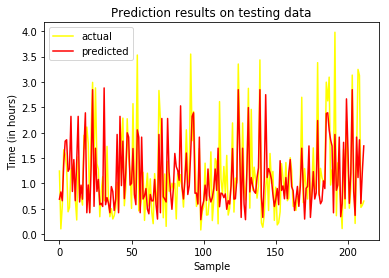

In [16]:
plt.plot(Y_tst, color= 'yellow', label= 'actual') # p
plt.plot(predict_model, color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()